In [12]:
# user specific setup 
# this should work fine as default but you might want to store data 
# other places so feel free to change the paths here

zip_folder = 'data_download_zip/' 
dl_data_folder = 'data/'

base_url = 'https://zenodo.org/record/8204334/files/'

ds20_url = base_url + 'ds20.zip'
ds100_url = base_url + 'ds100.zip'

ds20_zipfile = zip_folder + 'ds20.zip'
ds100_zipfile = zip_folder  + 'ds100.zip'

ds20_data_folder = dl_data_folder + 'ds20/'
ds100_data_folder = dl_data_folder + 'ds100/'

ds20_model_folder = 'models/ds20/'
ds100_model_folder = 'models/ds100/'


EDGE_WGT = 9. 

our_rando_seed = 417417



In [3]:
# Training setup.  

NL = [4, 5, 6, 7] # number of layers to be trained 
NC = [20, 30, 40] # number of channels 
NH = [4, 5, 6, 7] # number of hops 

hp_idx = [
    (nl, nc, nh) 
    for nl in NL 
    for nc in NC  
    for nh in NH 
]


In [4]:
from typing import Dict,  List, Callable
import os 
from requests import get 
import zipfile

import h5py
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import networkx as nx 

import torch 
from torch import tensor
import torch.optim as optim
from torch.nn import MSELoss
from torch_geometric.nn import TAGConv
from torch_geometric.data import DataLoader
from torch_geometric.data import Data 


In [13]:
# loading data 
# This will take maybe 30 seconds initially.  
# Seecond time you should not notice the lag.  


def mkdir_if_not_exist(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)

def make_path_if_not_exist(file):
    folder = os.path.dirname(file)
    mkdir_if_not_exist(folder)

def load_from_source(url, file, overwrite=False):
    make_path_if_not_exist(file)
    if not os.path.exists(file) or overwrite:
        with open(file, 'wb') as f:
            response = get(url)
            f.write(response.content)
            print(f"Downloaded {url} to {file}")
            f.close()

    else:
        print(f"File {file} already exists. Set overwrite=True to overwrite")

load_from_source(ds20_url, ds20_zipfile)
load_from_source(ds100_url, ds100_zipfile)


File data_download_zip/ds20.zip already exists. Set overwrite=True to overwrite
File data_download_zip/ds100.zip already exists. Set overwrite=True to overwrite


In [16]:
# now extract from zip files and load the data 
def extract_zip(zipfile_name, folder):
    zf = zipfile.ZipFile(zipfile_name)
    zf.extractall(folder)
    zf.close()

extract_zip(ds20_zipfile, dl_data_folder)
extract_zip(ds100_zipfile, dl_data_folder)


In [17]:
# read in hd5 data 
# This is quite slow, taking about 3 minutes.  
def load_data(ds: str, type:str, data_folder:str, batch_size=500) -> DataLoader:  

    folder_name = f"{data_folder}/{ds}/{type}/"

    file_name_input = f"{folder_name}/input_data.h5"
    file_name_snbs = f"{folder_name}/snbs.h5"

    snbs_data = h5py.File(file_name_snbs, 'r')
    input_data = h5py.File(file_name_input, 'r')['grids']

    grid_data = [
        Data(
            x = tensor(np.array(id_v['node_features']).reshape(-1, 1), dtype=torch.float),
            edge_index = tensor(np.array(id_v['edge_index']).T - 1, dtype=torch.long),
            edge_attr = tensor(np.full(shape=id_v['edge_index'].shape[0], fill_value=EDGE_WGT), dtype=torch.float),
            y = tensor(np.array(snbs_v), dtype=torch.float)
        )
        for id_v, snbs_v in zip(input_data.values(), snbs_data.values())
    ]

    return DataLoader(grid_data, batch_size=batch_size)

def load_dataset(ds:str, data_folder: str) -> Dict[str, DataLoader]: 
    res= dict() 
    res['train_ds'] = load_data(ds=ds, type='train', data_folder=data_folder)
    res['test_ds'] = load_data(ds=ds, type='test', data_folder=data_folder)
    res['valid_ds'] = load_data(ds=ds, type='valid', data_folder=data_folder)
    return res 

data_ds20 = load_dataset('ds20', dl_data_folder)
data_ds100 = load_dataset('ds100', dl_data_folder)


c:\Users\nbjce1\Anaconda3\envs\uda_project_autumn_2024\lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [9]:
# test how the dtaset looks like 

print(data_ds20['train_ds'].dataset[0])

Data(x=[20, 1], edge_index=[2, 54], edge_attr=[54], y=[20])


In [14]:
class TAGConvModule(torch.nn.Module):
    def __init__(self, channels_in, channels_out, K_hops, activation, batch_norm) -> None:
        super().__init__()
        self.channels_in = channels_in
        self.channels_out = channels_out
        self.K_hops = K_hops
        self.activation = activation
        self.batch_norm = batch_norm

        self.conv = TAGConv(
            self.channels_in, 
            self.channels_out, 
            K=self.K_hops
        )
        if self.batch_norm:
            self.batch_norm_layer = torch.nn.BatchNorm1d(self.channels_out)

    def forward(self, data, x):
        # Add safety checks
        num_nodes = x.size(0)
        if data.edge_index.max() >= num_nodes:
            raise ValueError(f"Edge index contains invalid node indices. Max index: {data.edge_index.max()}, num nodes: {num_nodes}")
        
        if data.edge_index.min() < 0:
            raise ValueError(f"Edge index contains negative indices: {data.edge_index.min()}")
            
        # Apply convolution
        x = self.conv(x, data.edge_index, data.edge_attr)
        
        if self.batch_norm:
            x = self.batch_norm_layer(x)
        
        x = self.activation(x)
        return x
    
class TAGNet(torch.nn.Module):
    def __init__(
        self, 
        no_layers: int,
        channels: List[int],
        activation: List[Callable],
        K_hops: List[int],
        batch_norm: List[bool],
        final_linear_layer: bool,
        final_sigmoid_layer: bool = True, 
    ) -> None:
        super(TAGNet, self).__init__()

        self.no_layers = no_layers
        self.channels = channels
        self.activation = activation
        self.K_hops = K_hops
        self.batch_norm = batch_norm
        self.final_linear_layer = final_linear_layer
        self.final_sigmoid_layer = final_sigmoid_layer


        self.convlist = torch.nn.ModuleList([
            TAGConvModule(
                channels_in=self.channels[i],
                channels_out=self.channels[i+1],
                activation=self.activation[i],
                K_hops=self.K_hops[i],
                batch_norm=self.batch_norm[i]
            )
            for i in range(self.no_layers)
        ])

        if self.final_linear_layer:
            self.endLinear = torch.nn.Linear(self.channels[-1], 1)
        if self.final_sigmoid_layer: 
            self.endSigmoid = torch.nn.Sigmoid()

    def forward(self, data):
        x = data.x
        
        for conv in self.convlist:
            x = conv(data, x)
            
        if self.final_linear_layer:
            x = self.endLinear(x)
        if self.final_sigmoid_layer: 
            x = self.endSigmoid(x)
        
        return x.squeeze(-1)  # Match target shape

from torchmetrics import R2Score

class TAGModule(torch.nn.Module): 
    def __init__(
        self, 
        channels, 
        activation,
        K_hops,
        batch_norm,
        final_linear_layer, 
        final_sigmoid_layer
    ) -> None:
        
        torch.manual_seed(our_rando_seed)
        torch.cuda.manual_seed(our_rando_seed)
        np.random.seed(our_rando_seed)        

        super(TAGModule, self).__init__()
        self.model = TAGNet(
            no_layers=len(channels) - 1,
            channels=channels,
            activation=activation,
            K_hops=K_hops,
            batch_norm=batch_norm,
            final_linear_layer=final_linear_layer,
            final_sigmoid_layer=final_sigmoid_layer
        )
        self.device = torch.device('cpu')
        self.model.to(self.device)
        self.criterion = MSELoss(reduction='mean')
        self.optimizer = optim.SGD(
            self.model.parameters(), lr=3, momentum=0.9
        ) 

        self.scheduler = optim.lr_scheduler.StepLR(
            self.optimizer, step_size=10, gamma=0.1
        )

        self.r2score = R2Score().to(self.device)
    
    def forward(self, x): 
        return self.model(x)

    def train_epoch(self, data_loader, threshold=0.1): 
        self.model.train() 
        all_labels = torch.Tensor(0).to(self.device)
        all_preds = torch.Tensor(0).to(self.device)
        correct = 0 
        for _, (batch) in enumerate(data_loader):
            batch.to(self.device)
            self.optimizer.zero_grad()
            outputs = torch.squeeze(self.model.forward(batch))
            loss = self.criterion(outputs, batch.y)
            loss.backward()
            self.optimizer.step()
            correct += torch.sum(( torch.abs(outputs-batch.y) < threshold ))
            all_labels = torch.cat([all_labels, batch.y])
            all_preds = torch.cat([all_preds, outputs])

        accuracy = correct / all_labels.shape[0]
        r2_score = self.r2score(all_preds, all_labels)

        return accuracy, r2_score

    def eval_model(self, data_loader, threshold=0.1): 
        self.model.eval() 
        correct = 0 
        all_labels = torch.Tensor(0).to(self.device)
        all_preds = torch.Tensor(0).to(self.device)

        with torch.no_grad(): 
            for _, (batch) in enumerate(data_loader):
                batch.to(self.device)
                outputs = torch.squeeze(self.model(batch))
                correct += torch.sum(( torch.abs(outputs-batch.y) < threshold ))
                all_labels = torch.cat([all_labels, batch.y])
                all_preds = torch.cat([all_preds, outputs])

        accuracy = correct / all_labels.shape[0]
        r2_score = self.r2score(all_preds, all_labels)

        return accuracy, r2_score
        

# Update your model initialization
tag_net = TAGNet(
    no_layers=3,
    channels=[1, 32, 32, 1],  # Make sure dimensions match
    activation=[torch.nn.ReLU()] * 3,
    K_hops=[2] * 3,
    batch_norm=[True] * 3, 
    final_linear_layer=True
)

tag_module = TAGModule(
    channels=[1, 30, 30, 1],
    activation=[torch.nn.ReLU()] * 3,
    K_hops=[3] * 3,
    batch_norm=[True] * 3,
    final_linear_layer=False,
    final_sigmoid_layer=True
)


def make_tag_module(num_layers, num_channels, num_hops): 
    return TAGModule(
        channels=[1] + [num_channels] * (num_layers - 1) + [1],
        activation=[torch.nn.ReLU()] * num_layers,
        K_hops=[num_hops] * num_layers,
        batch_norm=[True] * num_layers,
        final_linear_layer=False,
        final_sigmoid_layer=True
    )

In [34]:
# use now TAGModule to train model 

def train_model(tag_module, data_loader, epochs, patience_limit=50, print_at=None):
    best_so_far = -np.inf
    patienc_eused=0
    all_train_acc = [] 
    all_train_r2 = [] 
    all_test_acc = [] 
    all_test_r2 = [] 
    
    for epoch in range(epochs):
        train_acc, train_r2 = tag_module.train_epoch(data_loader['train_ds'], threshold=0.05)
        valid_acc, valid_r2 = tag_module.eval_model(data_loader['valid_ds'], threshold=0.05)
        if valid_r2 > best_so_far:
            best_so_far = valid_r2
            patienc_eused = 0
        else:
            patienc_eused += 1
            if patienc_eused > patience_limit:
                print(f"Early stopping at epoch {epoch}")
                break
        if print_at: 
            if epoch % print_at == 0:
                print(f"Epoch {epoch}: Train accuracy: {train_acc:.2f}, Train R2: {train_r2:.2f}, Valid accuracy: {valid_acc:.2f}, Valid R2: {valid_r2:.2f}")

        all_train_acc.append(float(train_acc))
        all_train_r2.append(float(train_r2.item()))
        all_test_acc.append(float(valid_acc))
        all_test_r2.append(float(valid_r2.item()))

    hist = {
        'train_acc': np.array(all_train_acc), 
        'train_r2': np.array(all_train_r2), 
        'valid_acc': np.array(all_test_acc), 
        'valid_r2': np.array(all_test_r2), 
    }
    return hist 



In [67]:
# training models 
model_dict = dict() 
hist_dict = dict() 

#make dir trained_models/ if not exists 
for subdir in [
        'trained_models_ds20', 'training_hist_ds20', 
        'trained_models_ds100', 'training_hist_ds100', 
    ]:  
    if not os.path.exists(subdir):
        os.makedirs(subdir)

# print("="*20)
# print("="*20) 
# print("20 NODE TRAINING SET")


def train_batch(
        index_set, 
        which='ds20', 
        overwrite=False, 
        epochs=400, 
        patience_limit=400,
        ): 
    training_folder = f'trained_models_{which}/'
    hist_folder = f'training_hist_{which}/'

    # make folders if not exist 
    mkdir_if_not_exist(training_folder)
    mkdir_if_not_exist(hist_folder)

    for idx in index_set: 
        training_file_name = training_folder + f'model_{str(idx)}.pth'
        if os.path.exists(training_file_name) and not overwrite:
            print(f"Model {str(idx)} already trained. Skipping")
            continue

        print(f'Training {str(idx)}..')
        model_dict[idx] = make_tag_module(
            num_layers=idx[0], 
            num_channels=idx[1], 
            num_hops = idx[2]
            )
        hist_dict[idx] = train_model(
            model_dict[idx], 
            data_ds20, 
            epochs = epochs, 
            patience_limit=patience_limit, 
            print_at=50
        )

        torch.save(model_dict[idx], training_folder + f'model_{str(idx)}.pth') 
        # transform hist dict into json and save too 
        tmp_dict = {
            k: list(v) 
            for k, v in hist_dict[idx].items() 
        }
        import json 
        json.dump(
            tmp_dict, 
            open(f'{hist_folder}/{str(idx)}.pth', 'w') 
            )

    print("done.")

# train_batch([(4, 20, 4)], patience_limit=5, epochs=5)

# print("="*20)
# print("="*20) 
# print("100 NODE TRAINING SET")

# for idx in hp_idx: 
#     print("="*20)
#     print(f'Training {str(idx)}..')
#     model_dict[idx] = make_tag_module(
#         num_layers=idx[0], 
#         num_channels=idx[1], 
#         num_hops = idx[2]
#         )
#     hist_dict[idx] = train_model(
#         model_dict[idx], 
#         data_ds20, 
#         epochs = 400, 
#         patience_limit=400, 
#         print_at=50
#     )

#     torch.save(model_dict[idx], f'trained_models_ds100/model_{str(idx)}.pth') 
#     # transform hist dict into json and save too 
#     tmp_dict = {
#         k: list(v) 
#         for k, v in hist_dict[idx].items() 
#     }
#     import json 
#     json.dump(
#         tmp_dict, 
#         open(f'training_hist_ds100/{str(idx)}.pth', 'w') 
#         )


In [25]:
import torch_geometric
import torch 
from torch_geometric.nn import TAGConv
import json 
# read in trained model and training data 

def read_hist_data(which:str):
    hist = dict()
    hist_folder = f'training_hist_{which}'
    for idx in hp_idx: 
        hist[idx] = json.load(open(f'{hist_folder}/{str(idx)}.pth'))
    return hist


def load_tag_model(which:str, my_idx:list = hp_idx) -> Dict:
    model_dict = dict() 
    training_folder = f'trained_models_{which}'
    for idx in my_idx: 
        model_dict[idx] = torch.load(f"{training_folder}/model_{str(idx)}.pth")
    return model_dict

model_dict = load_tag_model('ds20', [(4,20,4)])
tm = model_dict[(4, 20, 4)]



In [7]:
# we try to find the right hyperparameters to dial up.  

init_nl = 3
increase_nl = 1

init_nc = 10 
increase_nc = 5

init_nh = 2 
increase_nh = 1 

nh, nl, nc = init_nh, init_nl, init_nc

counter = 0 
max_count = 10 

def train_single_model(nl, nc, nh, data, epochs=400, patience_limit=15, print_at=50): 
    return train_batch(
        [(nl, nc, nh)], which='ds20', patience_limit=patience_limit, 
        epochs=epochs, overwrite=True, print_at=print_at
    )[(nl, nc, nh)]



perf = dict() 

# initial performance 



while counter < max_count:  
    # we increase each of the hyperparameters, calculate performance 
    # and compare R2 score.


    



SyntaxError: incomplete input (329658655.py, line 37)

In [28]:
# count number of parameters in model
nl = 4 
nc = 20
nh = 4

def calc_params(nl, nc, nh): 
    my_idx = (nl, nc, nh)
    train_batch([my_idx], patience_limit=2, epochs=2)

    tm = load_tag_model('ds20', [my_idx])[my_idx]

    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f" Index {my_idx}.   Act params: {count_parameters(tm)/1e3}, estimated {(nl-1)*nc*nc*nh/1e3}")

for nl in NL: 
    for nc in NC: 
        for nh in NH: 
            calc_params(nl, nc, nh)


NameError: name 'train_batch' is not defined

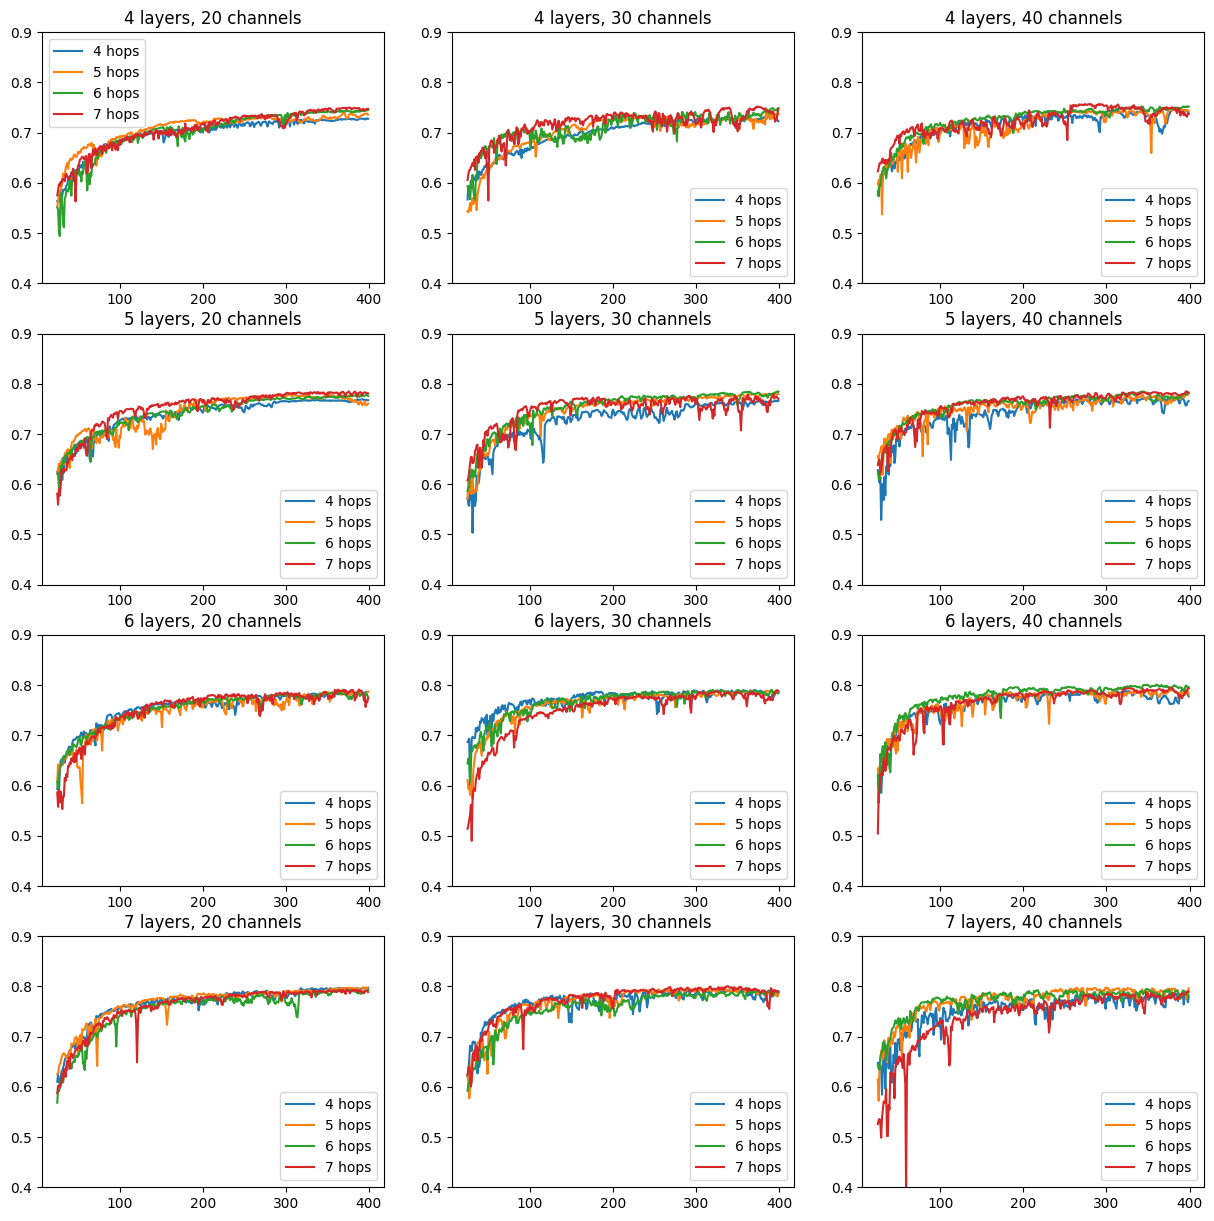

In [26]:
from matplotlib import pyplot as plt 
# we dissect the indices again 
fig, axs = plt.subplots(len(NL), len(NC), figsize=(15, 15))

for i, nl in enumerate(NL): 
    for j, nc in enumerate(NC): 
        ax = axs[i,j]
        for nh in NH: 
            ts = hist_dict[(nl, nc, nh)]['valid_r2']
            L = len(ts)
            epochs = np.arange(L)
            eps = epochs[25:]
            t = ts[25:]
            l = str(nh) + " hops"
            ax.plot(eps, t, label=l)
            ax.legend()
            ax.set_ylim(0.4,0.9)
            ax.grid()
            ax.set_title(f"{nl} layers, {nc} channels")

plt.show() 


,no_params,r2_eval
"(4, 20, 4)",4383,-0.849358
"(4, 20, 5)",5223,-0.718159
"(4, 20, 6)",6063,-1.682874
"(4, 20, 7)",6903,-0.489308
"(4, 30, 4)",9573,-1.398177
"(4, 30, 5)",11433,-0.904435
"(4, 30, 6)",13293,-0.834955
"(4, 30, 7)",15153,-0.267426
"(4, 40, 4)",16763,-0.940302
"(4, 40, 5)",20043,-0.627402


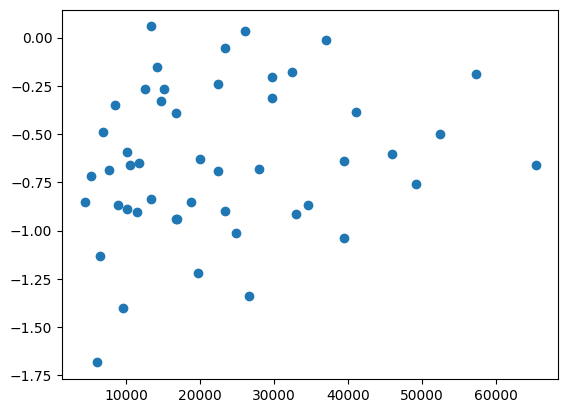

In [31]:
# for a given index and which, read in model and data and return the model and data.

def read_model(which:str, idx:tuple):
    return load_tag_model(which, [idx])[idx]

def perf_size_model(which:str, idx:tuple):
    tm = read_model('ds20', idx)

    no_params = sum(p.numel() for p in tm.parameters() if p.requires_grad)
    # get R2 on the test set 

    r2_eval = tm.eval_model(data_ds20['test_ds'], threshold=0.05)[1]


    return no_params, r2_eval.float().item()

df_perf = pd.DataFrame(
    [
        perf_size_model('ds20', idx) 
        for idx in hp_idx
    ], 
    columns=['no_params', 'r2_eval']
)
df_perf.index = hp_idx

display(df_perf)

# scatter plot 

plt.scatter(df_perf['no_params'], df_perf['r2_eval'])
plt.show()


In [ ]:
# illustration of in-/output 

def plot_graph(
        data, node_labels, ax=None, 
        title=None, node_size=100, 
        cmap='RdYlGn',
        vmin=None, vmax=None,
        add_colorbar=False,
        colorbar_label=None):
    
    edges = data.edge_index.numpy()
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.set_title(title)
    ax.set_aspect('equal')

    G = nx.Graph()
    G.add_nodes_from(range(node_labels.shape[0]))
    G.add_edges_from(edges.T)

    pos = nx.kamada_kawai_layout(G)

    nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_color='black',  # ring color
        node_size=node_size  + min(max(40., 0.4*node_size), 20.),  # slightly larger size for the ring
    )
    # Draw the graph
    nodes = nx.draw_networkx_nodes(
        G, pos, ax=ax, node_color=node_labels, 
        cmap=cmap, node_size=node_size,
        vmin=vmin, vmax=vmax  # Add these parameters for consistent color scaling
        )
    edges = nx.draw_networkx_edges(G, pos, ax=ax)
    
    if add_colorbar:
        # Add colorbar with percentage formatting
        cbar = plt.colorbar(nodes, ax=ax)
        if colorbar_label:
            cbar.set_label(colorbar_label)
        cbar.ax.yaxis.set_major_formatter(
            PercentFormatter(xmax=1.0, decimals=0)
            )

def plt_snbs(data, pred_snbs, node_size=100):

    P = data.x.numpy()
    snbs = data.y.numpy()

    # Create the plot with equal sizes and shared colorbar
    fig = plt.figure(figsize=(15, 5))
    gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1.2])  # Slightly wider last subplot for colorbar

    axs = [fig.add_subplot(gs[0, i]) for i in range(3)]

    # Get the full range of values for consistent colormap
    vmin = min(snbs.min(), pred_snbs.min())
    vmax = max(snbs.max(), pred_snbs.max())


    # Plot each graph

    # first graph gets a purple/orange colormap 
    plot_graph(
        data, P, ax=axs[0], 
        title='Grid, Source (purple) / Sink (red)', 
        vmin=-1, vmax=1, cmap=mcolors.ListedColormap(['purple', 'orange']), 
        node_size=node_size
        )

    plot_graph(data, snbs, ax=axs[1], title='True SNBS', vmin=vmin, vmax=vmax, 
        node_size=node_size)
    nodes = plot_graph(data, pred_snbs, ax=axs[2], title='Predicted SNBS', 
                    vmin=vmin, vmax=vmax, add_colorbar=True, 
                    colorbar_label='SNBS', 
        node_size=node_size)

    plt.tight_layout()

data = data_ds100['train_ds'].dataset[0]
pred_snbs = tag_module(data).detach().numpy()
plt_snbs(data, pred_snbs, node_size=30)
plt.savefig('sample_graph_100.png')
plt.show()

data = data_ds20['train_ds'].dataset[0]
pred_snbs = tag_module(data).detach().numpy()
plt_snbs(data, pred_snbs, node_size=100)
plt.savefig('sample_graph_20.png')
plt.show()


